In [67]:
import pandas as pd
pd.set_option('display.max_columns', None) # sets the max 
sns.set_style("whitegrid")
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [125]:
df = pd.read_csv('data/student_data.csv')
features = df.columns
df.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,course,mother,2,2,0,yes,no,no,no,yes,yes,no,no,4,3,4,1,1,3,6,5,6,6
1,GP,F,17,U,GT3,T,1,1,at_home,other,course,father,1,2,0,no,yes,no,no,no,yes,yes,no,5,3,3,1,1,3,4,5,5,6
2,GP,F,15,U,LE3,T,1,1,at_home,other,other,mother,1,2,3,yes,no,yes,no,yes,yes,yes,no,4,3,2,2,3,3,10,7,8,10
3,GP,F,15,U,GT3,T,4,2,health,services,home,mother,1,3,0,no,yes,yes,yes,yes,yes,yes,yes,3,2,2,1,1,5,2,15,14,15
4,GP,F,16,U,GT3,T,3,3,other,other,home,father,1,2,0,no,yes,yes,no,yes,yes,no,no,4,3,2,1,2,5,4,6,10,10


# Feature engineering

In [131]:
df_altered = df.copy()

df_altered['famsize'] = df_altered['famsize'].map({'GT3': 1, 'LE3': 2})
df_altered['Pstatus'] = df_altered['Pstatus'].map({'A': 1, 'T': 2}) # 1 = Apart, 2 = Together

df_altered

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,1,A,4,4,at_home,teacher,course,mother,2,2,0,yes,no,no,no,yes,yes,no,no,4,3,4,1,1,3,6,5,6,6
1,GP,F,17,U,1,T,1,1,at_home,other,course,father,1,2,0,no,yes,no,no,no,yes,yes,no,5,3,3,1,1,3,4,5,5,6
2,GP,F,15,U,2,T,1,1,at_home,other,other,mother,1,2,3,yes,no,yes,no,yes,yes,yes,no,4,3,2,2,3,3,10,7,8,10
3,GP,F,15,U,1,T,4,2,health,services,home,mother,1,3,0,no,yes,yes,yes,yes,yes,yes,yes,3,2,2,1,1,5,2,15,14,15
4,GP,F,16,U,1,T,3,3,other,other,home,father,1,2,0,no,yes,yes,no,yes,yes,no,no,4,3,2,1,2,5,4,6,10,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
390,MS,M,20,U,2,A,2,2,services,services,course,other,1,2,2,no,yes,yes,no,yes,yes,no,no,5,5,4,4,5,4,11,9,9,9
391,MS,M,17,U,2,T,3,1,services,services,course,mother,2,1,0,no,no,no,no,no,yes,yes,no,2,4,5,3,4,2,3,14,16,16
392,MS,M,21,R,1,T,1,1,other,other,course,other,1,1,3,no,no,no,no,no,yes,no,no,5,5,3,3,3,3,3,10,8,7
393,MS,M,18,R,2,T,3,2,services,other,course,mother,3,1,0,no,no,no,no,no,yes,yes,no,4,4,1,3,4,5,0,11,12,10


## Average Grade

In [43]:
# AVG grade of each student
grad_mean= (df.G1 + df.G2 + df.G3) / 3
df['G_Mean'] = grad_mean

numeric_features = df.select_dtypes("number")

## Social Class (same socioeconomic status)
we are dividing social class into 3 groups; upper (U), middle (M) and lower (L) class.

- Parents educational level is the strongest proxy for social class
- Parents job is the second strongest proxy
- health???
- freetime after school
- internet
- extra-curricular activities
- family size

In [112]:
# Inferring social class based on parents education
print(f"{df[(df['Medu'] == 4) & (df['Fedu'] == 4)].shape[0]} rows where both mother and father has higher education")
print(f"{df[(df['Medu'] == 4) ^ (df['Fedu'] == 4)].shape[0]} rows where either mother or father has higher education (bot not both)")
print(f"{df[(df['Medu'] < 4) & (df['Fedu'] < 4)].shape[0]} rows where both the mother or father does not have a higher education")

70 rows where both mother and father has higher education
87 rows where either mother or father has higher education (bot not both)
238 rows where both the mother or father does not have a higher education


In [119]:
df[(df['Medu'] == 4) & (df['Fedu'] == 4) & (df['internet'] == "yes")].shape[0]

62

In [116]:
df["social_class"] = df.apply(
    lambda x: "upper"
    if x["Medu"] == 4 and x["Fedu"] == 4
    else "middle"
    if x["Medu"] == 4 ^ x["Fedu"] == 4
    else "lower",
    axis=1,
)

In [ ]:
# Mothers and fathers education level can be proxies for social class

In [103]:
df['Medu'].value_counts()

Medu
4    131
2    103
3     99
1     59
0      3
Name: count, dtype: int64

In [102]:
df['Fedu'].value_counts()

Fedu
2    115
3    100
4     96
1     82
0      2
Name: count, dtype: int64

# EDA

## Sensitive Variables

### AGE

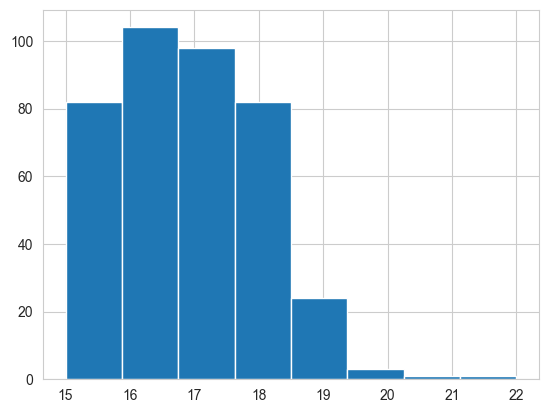

In [91]:
plt.hist(df['age'], bins=8)
plt.show()

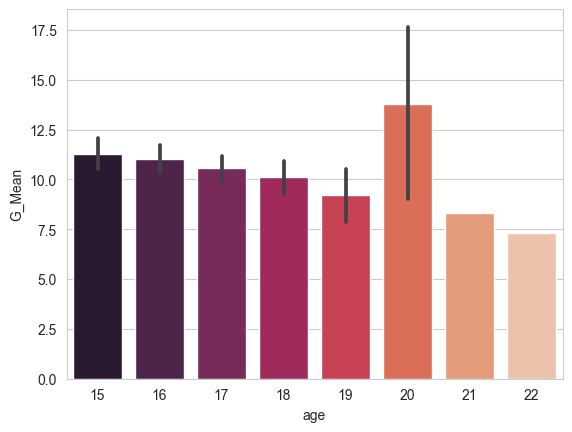

In [78]:
sns.barplot(data=df, x="age", y="G_Mean", palette="rocket", errorbar=("ci", 95))
plt.show()

In [79]:
df.age.value_counts()

age
16    104
17     98
18     82
15     82
19     24
20      3
22      1
21      1
Name: count, dtype: int64

<Axes: xlabel='age', ylabel='studytime'>

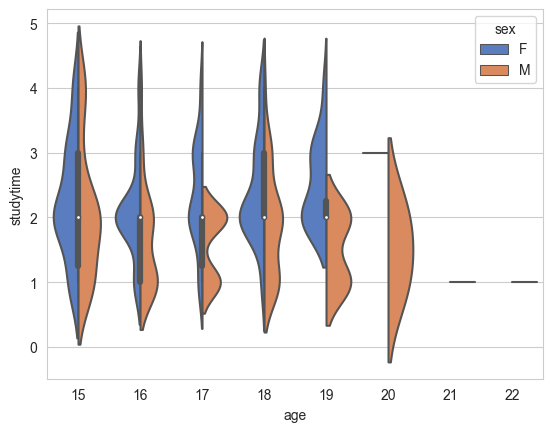

In [19]:
sns.violinplot(x="age", y="studytime", hue="sex", data=df, palette="muted", split=True)

<Axes: xlabel='age', ylabel='failures'>

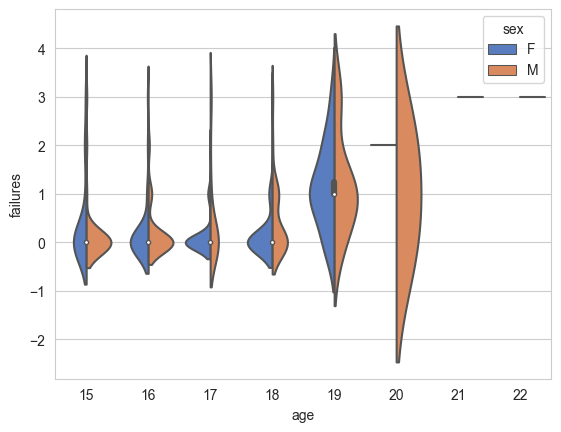

In [22]:
sns.violinplot(x="age", y="failures", hue="sex", data=df, palette="muted", split=True)

### SEX

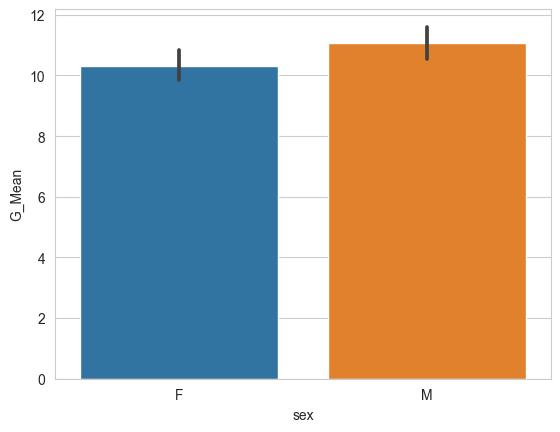

In [52]:
sns.barplot(x= 'sex', y = 'G_Mean', data = df)
plt.show()

In [100]:
display(df.groupby("sex").G1.mean())
display(df.groupby("sex").G2.mean())
display(df.groupby("sex").G3.mean())
display(df.groupby("sex").G_Mean.mean())

sex
F    10.620192
M    11.229947
Name: G1, dtype: float64

sex
F    10.389423
M    11.074866
Name: G2, dtype: float64

sex
F     9.966346
M    10.914439
Name: G3, dtype: float64

sex
F    10.325321
M    11.073084
Name: G_Mean, dtype: float64

Males are on average getting a higher grade than females

## Non-sensitive variables

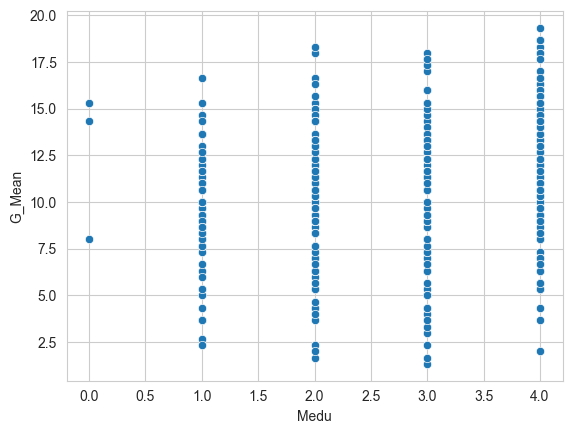

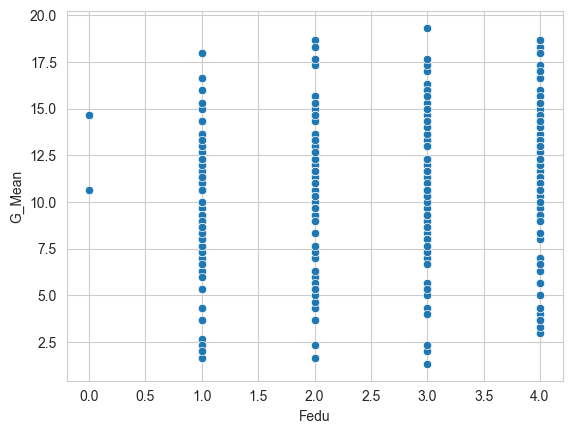

In [60]:
sns.scatterplot(x = 'Medu', y = 'G_Mean', data = df)
plt.show()
sns.scatterplot(x = 'Fedu', y = 'G_Mean', data = df)
plt.show()